In [1]:
# import all of the dependencies i used in data visualization notebook
import re
import plotly 
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='bakeralex664', api_key='a7vexR1Pli50bFWRXdJp')

# Aim of this Notebook:

The purpose of this notebook is to conduct a **post interview Exploratory Data Analysis (EDA)** of Cohen et al. 2018 provided data. While, I was preparing for my interview with the CRUK-CI Rosenfeld group I developed data visualizations and model improvements without gaining a truly comprehensive understanding of the dataset. I primarily stuck to Cohen et al. 2018 protcol for data analysis and essentially adopted there perspective on the data.

**Personal Perspective:**

Now it is post interview. I now have the time to properly integrate and explore the data. Throughout the course of Cohen et al 2018 paper they never mentioned any real in depth analysis of there biomaker and omega score data. More importantly the way they built there model was fundamentally biased. Especially in regards to the attempt to develop a model that could predict tissue of origin of cancer.

The source of Cohen et al. 2018 model bias was in how they trained their models. Specifically for their logistic regression model they trained it to detect cancer or healthy. They failed to study the potiential distribution of data points by cancer type and how observed outliers cancer patients my concentrate to particular types of cancer.

**Personal Aim**

I want to understand why I was able to achieve a dramatic increase in model accuracy in comparison to Cohen et al. 2018. From this understanding could I potientially develop a tissue localization model from this data.

# Data Preparation for EDA

The following sections of code are related to cleaning, loading, and transforming the necessary datasets in pandas dataframes. Finally, we merge all of these pandas dataframes into one dataframe for EDA.

In [2]:
s4 = pd.read_csv('../data/clinical_characteristics_cohen_s4.csv')
s5 = pd.read_csv('../data/mutations_id_in_plasma_cohen_s5.csv')
s6 = pd.read_csv('../data/protein_biomarker_assay_cohen_s6.csv')

In [3]:
s4.head()

,Patient ID #,Plasma sample ID #,Primary tumor sample ID #,Age,Sex,Race,Tumor type,AJCC Stage,Histopathology,Plasma volume (mL),Plasma DNA concentration (ng/mL),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Not available,60,Male,Caucasian,Colorectum,I,Adenocarcinoma,5.0,6.08,0.938,Positive
1,CRC 456,CRC 456 PLS 1,CRC 456 PT1,59,Female,Caucasian,Colorectum,I,Adenocarcinoma,4.0,46.01,0.925,Positive
2,CRC 457,CRC 457 PLS 1,CRC 457 PT1,69,Female,Caucasian,Colorectum,II,Adenocarcinoma,4.5,6.94,0.852,Negative
3,CRC 458,CRC 458 PLS 1,CRC 458 PT1,70,Female,Caucasian,Colorectum,II,Adenocarcinoma,7.5,7.15,0.618,Negative
4,CRC 459,CRC 459 PLS 1,CRC 459 PT1,43,Female,Caucasian,Colorectum,II,Adenocarcinoma,5.0,9.81,0.318,Negative


In [4]:
s5.head()

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,Plasma volume (mL),Plasma DNA concentration (ng/mL),Mutation identified in plasma*,Ω score,Mutant allele frequency (%),Mutant fragments/mL plasma,CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Colorectum,I,5.0,6.08,"TP53 p.K120E, c.358A>G",2.96,0.27,5.1,0.938,Positive
1,CRC 456,CRC 456 PLS 1,Colorectum,I,4.0,46.01,"TP53 p.S240I, c.719G>T",2.45,0.02,3.2,0.925,Positive
2,CRC 457,CRC 457 PLS 1,Colorectum,II,4.5,6.94,"TP53 p.R202C, c.604C>T",1.22,0.06,1.4,0.852,Negative
3,CRC 458,CRC 458 PLS 1,Colorectum,II,7.5,7.15,"TP53 p.R248Q, c.743G>A",1.64,0.16,3.6,0.618,Negative
4,CRC 459,CRC 459 PLS 1,Colorectum,II,5.0,9.81,"TP53 p.A276G, c.827C>G",1.33,0.08,2.5,0.318,Negative


In [5]:
s6.head()

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Colorectum,I,1583.450,5598.50,3621.04,5.090,19.08,16.452,...,204.792,55.06,6832.0700,9368.53,16.086,21863.74,56428.71,39498.82,0.938,Positive
1,CRC 456,CRC 456 PLS 1,Colorectum,I,715.308,20936.35,2772.96,7.270,10.04,40.910,...,204.792,72.92,5549.4700,6224.55,16.086,29669.66,73940.49,41277.09,0.925,Positive
2,CRC 457,CRC 457 PLS 1,Colorectum,II,4365.530,2350.93,4120.77,4.854,16.96,16.452,...,204.792,173.78,3698.1600,4046.48,179.030,6020.47,22797.28,28440.60,0.852,Negative
3,CRC 458,CRC 458 PLS 1,Colorectum,II,715.308,1604.34,2029.96,5.390,8.31,16.452,...,204.792,29.47,0.5856,6121.93,16.086,4331.02,20441.19,25896.73,0.618,Negative
4,CRC 459,CRC 459 PLS 1,Colorectum,II,801.300,2087.57,2069.17,4.854,11.73,16.452,...,204.792,78.07,5447.9300,6982.32,16.086,2311.91,56288.51,49425.20,0.318,Negative


In [21]:
# collecting and renaming all of the data features from the different supplementary tables i wish to work with
collated_dict = {
    "patient": s5['Patient ID #'].values,
    "sample": s5['Sample ID #'].values,
    "type": s5["Tumor type"].values,
    "stage": s5['AJCC Stage'].values,
    "age": s4['Age'].values,
    "sex": s4['Sex'].values,
    "race": s4['Race'].values,
    "histopathology": s4['Histopathology'].values,
    "dna_concentration": s5['Plasma DNA concentration (ng/mL)'].values,
    "plasma_volume": s5['Plasma volume (mL)'].values,
    "mutation_plasma": s5['Mutation identified in plasma*'].values,
    "omega_score": s5['Ω score'].values,
    "maf": s5['Mutant allele frequency (%)'].values,
    "mutant_fragments": s5[' Mutant fragments/mL plasma'].values
}

In [19]:
s6_protein = s6.ix[:, 'AFP (pg/ml)':]

for col in s6_protein.columns:
    collated_col = ""
    if 'CancerSEEK' in col:
        if 'Logistic' in col:
            collated_col = 'cancerseek_lr'
        else:
            collated_col = 'cancerseek_result'
    else:
        collated_col = col.split(" ")[0].lower()
    
    collated_dict[collated_col] = s6_protein[col].values

collated_df = pd.DataFrame.from_dict(collated_dict)

In [22]:
# extracting out the data used in CancerSeeks Logistic Regression along with some demographic data
lr_data = collated_df.ix[:,('ca-125','cea','ca19-9','prolactin','hgf','opn','myeloperoxidase','timp-1','omega_score','type','stage','age','race','sex','cancerseek_result')]

In [23]:
lr_data.head()

,ca-125,cea,ca19-9,prolactin,hgf,opn,myeloperoxidase,timp-1,omega_score,type,stage,age,race,sex,cancerseek_result
0,5.090,540.1,16.452,11606.60000,377.26,56516.58,14.22,56428.71,2.96,Colorectum,I,60,Caucasian,Male,Positive
1,7.270,5902.4,40.910,14374.99000,659.68,61001.39,23.88,73940.49,2.45,Colorectum,I,59,Caucasian,Female,Positive
2,4.854,973.8,16.452,0.38375,329.07,88896.24,12.02,22797.28,1.22,Colorectum,II,69,Caucasian,Female,Negative
3,5.390,2027.5,16.452,12072.51000,266.66,42549.61,6.49,20441.19,1.64,Colorectum,II,70,Caucasian,Female,Negative
4,4.854,614.5,16.452,23718.17000,370.88,24274.11,13.33,56288.51,1.33,Colorectum,II,43,Caucasian,Female,Negative


In [24]:
lr_data.describe()

,ca-125,cea,ca19-9,prolactin,hgf,opn,myeloperoxidase,timp-1,omega_score,age
count,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1751.000000,1817.000000
mean,25.174623,4411.505782,53.473383,31866.516381,322.296239,55463.101206,29.716840,69374.749150,4.439692,56.807925
std,184.586381,23699.449498,409.045047,53854.459030,488.246755,48219.683089,59.893963,47977.926002,21.161627,17.315452
min,0.500000,0.104000,0.139000,0.107920,0.166000,0.107431,0.100000,0.107736,0.000000,17.000000
25%,4.884000,594.550000,16.320000,8379.890000,164.172000,25937.250000,7.750000,40915.250000,0.710000,47.000000
50%,4.980000,1044.250000,16.482000,13804.260000,183.400000,40702.540000,12.620000,58878.610000,0.970000,60.000000
75%,6.400000,1924.610000,18.380000,26352.470000,292.670000,67901.160000,22.320000,82878.260000,1.320000,69.000000
max,3600.024000,337245.426000,12491.472000,608432.382000,11432.980000,433959.550000,618.290000,569512.690000,333.230000,93.000000



**Potiential Questions**:
   - Is there an unknown model bias towards detecting these types of cancer?

# Tumor Type Frequencies by Patient Count in CancerSEEK Dataset:

It's important to understand count distribution of patients with different cancer types in this dataset in order to ensure the stastical signifance of the data coming from each tumor type population. Smaller sample sets are more prone to containing extreme values that do not accurately reflect a population at large. 

In this case it's extremely important to bare this in mind as Cancer is not a monolith. Various cancer types may exhibit different patterns in the biomarker concentration levels.

**Results:**

As the barchart below demonstrates. The vast majority of patients are healthy individuals without cancer. This is to be except as the CancerSEEK paper boasts a large control population. However, the cancer patient populations are not numerically equal in there representation in this study. While, I am not sure how that affects the results of this study it is important to note that the most well represent cancer types are: Colorectum, Breast, Lung, and Pancreatic cancer. 

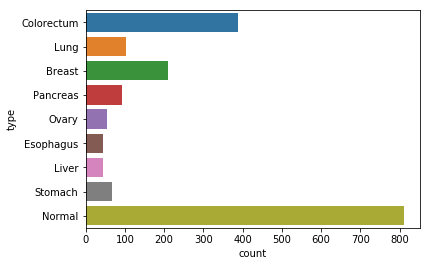

In [25]:
# trying to visualize tumor type in the dataset I am trying to analyze
# horizontal view of the barplot is easier to read and understand.
sns.countplot(y='type', data=lr_data)
plt.show()

# Exploring Model Accuracy by Tumor Type:

Cohen et al. 2018 model predictions count broken down by patient tumor count. As one can see tumor type samples contain high levels of false negative results. It's not exactly clear why this may be the case. Further analysis of the data's distribution and varience based on tumor type breakdown. 

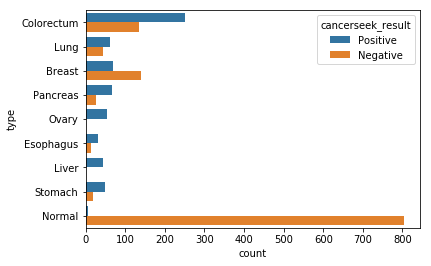

In [29]:
# trying to visualize tumor type in the dataset I am trying to analyze
# horizontal view of the barplot is easier to read and understand.
sns.countplot(y='type', hue='cancerseek_result', data=lr_data)
plt.show()

# EDA of CA-125 biomarker Concentration Levels:

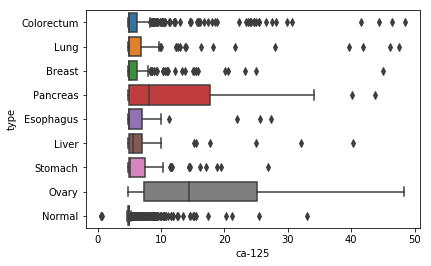

In [31]:
# creating a box plot a columns data distribution. I will also create a violin plot.

# this boxplot looks at ca-125 protein levels in the blood by cancer type. (Healthy is considered a type in this data)
# the extreme outliars of this population appear to be caused by ovary cancer. I need to remove them in order to 
# achieve better visualizations of the box plots. SIMPLY CUTTING OFF VALUES ABOVE 1000

ca_125_box = lr_data[lr_data['ca-125'] < 50]
sns.boxplot(x='ca-125', y='type', data=ca_125_box)
plt.show()

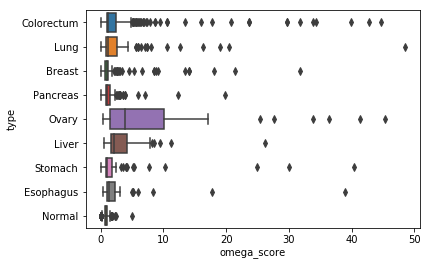

In [43]:
omega_box = lr_data[lr_data['omega_score'] < 50]
sns.boxplot(x='omega_score', y='type', data=omega_box)
plt.show()